In [555]:
import numpy as np
import matplotlib.pyplot as plt

In [556]:
# Rotations functions

def trotx(q):
    Tx = np.array([[1,         0,          0, 0],
                   [0, np.cos(q), -np.sin(q), 0],
                   [0, np.sin(q),  np.cos(q), 0],
                   [0,         0,          0, 1]])
    return Tx

def trotz(q):
    Tz = np.array([[np.cos(q), -np.sin(q),   0, 0],
                   [np.sin(q),  np.cos(q),   0, 0],
                   [        0,            0, 1, 0],
                   [        0,            0, 0, 1]])
    return Tz

In [557]:
# Derivative of Rotations

def dtrotx(q):
    dTx = np.array([[0,         0,          0,  0],
                   [ 0, -np.sin(q), -np.cos(q), 0],
                   [ 0,  np.cos(q), -np.sin(q), 0],
                   [ 0,         0,          0,  0]])
    return dTx

def dtrotz(q):
    dTz = np.array([[-np.sin(q), -np.cos(q), 0, 0],
                   [ np.cos(q),  -np.sin(q), 0, 0],
                   [        0,            0, 0, 0],
                   [        0,            0, 0, 0]])
    return dTz

In [558]:
# Translations functions

def translx(q):
    Tx = np.array([[1, 0, 0, q],
                   [0, 1, 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])
    return Tx

def translz(q):
    Tz = np.array([[1, 0, 0, 0],
                   [0, 1, 0, 0],
                   [0, 0, 1, q],
                   [0, 0, 0, 1]])
    return Tz

In [559]:
# Derivative of Translations

def dtranslx(q):
    dTx = np.zeros((4,4))
    dTx[0,3] = 1 
    return dTx

def dtranslz(q):
    dTz = np.zeros((4,4))
    dTz[2,3] = 1
    return dTz

In [560]:
# Forward
def fk(tool_pose, length):
    q1 = tool_pose[2] - length[0] - length[1]
    q2 = np.arctan2(tool_pose[2],tool_pose[1])
    q3 = np.sqrt(tool_pose[0]**2+tool_pose[1]**2) - length[1] - length[0]

    return np.array([q1,q2,q3])

# Inverse
def ik(q, theta, length):
   T01 = np.linalg.multi_dot([trotz(q[0]), trotz(theta[0]), translz(length[0])])
   T02 = np.linalg.multi_dot([T01, translz(theta[1]), translz(q[1]), translx(length[1])])
   T03 = np.linalg.multi_dot([T02, translx(q[2]), translx(theta[2])])
   return T03

In [561]:
def Ktheta(a, b, c):
    ktheta = np.array([[a, 0, 0],
                        [0, b,0],
                        [0, 0, c]], dtype = float)
    return ktheta

In [562]:
def Jk(links_length, theta, q):
    T = ik(q, theta, links_length)
    T[0:3,3] = np.array([0,0,0], dtype = float)
    T = T.T

    Td1 = np.linalg.multi_dot([trotz(q[0]), dtrotz(theta[0]), 
                               translz(links_length[1]), translz(theta[1]), 
                               translz(q[1]), translx(links_length[0]), translx(q[2]), translx(theta[1]), T])
    
    Td2 = np.linalg.multi_dot([trotz(q[0]), trotz(theta[0]), 
                               translz(links_length[1]), dtranslz(theta[1]), 
                               translz(q[1]), translx(links_length[0]), translx(q[2]), translx(theta[1]), T])

    Td3 = np.linalg.multi_dot([trotz(q[0]), trotz(theta[0]), 
                               translz(links_length[1]), translz(theta[1]), 
                               translz(q[1]), translx(links_length[0]), translx(q[2]), dtranslx(theta[1]), T])

    J1 = np.vstack([Td1[0,3], Td1[1,3], Td1[2,3], Td1[2,1], Td1[0,2], Td1[1,0]])

    J2 = np.vstack([Td2[0,3], Td2[1,3], Td2[2,3], Td2[2,1], Td2[0,2], Td2[1,0]])

    J3 = np.vstack([Td3[0,3], Td3[1,3], Td3[2,3], Td3[2,1], Td3[0,2], Td3[1,0]])
    
    Jt = np.hstack([J1, J2, J3])
    return Jt, J1, J2, J3

In [563]:
links_length = np.array([2, 1])
a, b, c = 10**6,2*10**6,0.5*10**6 # Stiffness coefficients
q = np.array([0.5, 1, 1]) # Position
theta = np.array([0,0,0]) # Angles
F = np.array([-400, 900, -1610, 100, -800, 0]) # Force

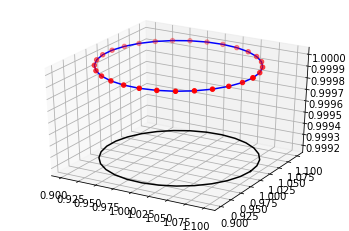

RED   - Desired
BLACK - Non Calibrated
BLUE  - Calibrated


In [564]:
ktheta = Ktheta(a, b, c)
matrix = np.zeros((3,3))
smatrix = np.zeros((3,1))

y = np.random.uniform(-100, 100, size = (6,1))
y = np.reshape(y, (6,1))
q = np.array([1.5, 0.3, 0.4])
Jt, J1, J2, J3 = Jk(links_length, theta, q)
dt = np.linalg.multi_dot([Jt, np.linalg.inv(ktheta), np.transpose(Jt), y]) 
wt = np.reshape(y[0:3], (3,1))

A1 = np.linalg.multi_dot([J1[0:3],np.transpose(J1[0:3]),wt])
A2 = np.linalg.multi_dot([J2[0:3],np.transpose(J2[0:3]),wt])
A3 = np.linalg.multi_dot([J3[0:3],np.transpose(J3[0:3]),wt])

obser_mat = np.hstack([A1, A2, A3])

dt = dt[0:3]
matr = matrix + np.linalg.multi_dot([np.transpose(obser_mat), obser_mat])
smatr = smatrix + np.linalg.multi_dot([np.transpose(A), dt])

        
ks = np.linalg.multi_dot([np.linalg.inv(matr), smatr])
stiffness = np.divide(1, ks)
    
robot = np.zeros((3, 30))

a = 1 + 0.1*np.cos(np.linspace(0, 2*np.pi, 30, dtype = float))
b = 1 + 0.1*np.sin(np.linspace(0, 2*np.pi, 30, dtype = float))
c = np.ones(30)
for i in range(30):
        robot[:,i] = fk([a[i], b[i], c[i]], links_length)

desired = np.stack([a, b, c])

# There is non calibration trajectory
noncol, colib = np.zeros((3,30)), np.zeros((3,30))

for i in range(0, 30):
        q = robot[:,i]
        Jt, J1, J2, J3 = Jk(links_length, theta, q)
        dt = np.linalg.multi_dot([Jt, np.linalg.inv(ktheta), np.transpose(Jt), F]) 
        noncol[:,i] = dt[0:3] + desired[:,i]

new = 2*desired - noncol  # new trajectory

# Here I do calibration 
for i in range(0, 30):
        q = robot[:,i]
        Jt, J1, J2, J3 = Jk(links_length, theta, q)
        dt = np.linalg.multi_dot([Jt, np.linalg.inv(ktheta), np.transpose(Jt), F]) 
        colib[:,i] = dt[0:3] + new[:,i]

fig  = plt.axes(projection = '3d')

fig.scatter(desired[0], desired[1], desired[2], c = 'red')
fig.plot(noncol[0], noncol[1], noncol[2], c = 'black')
fig.plot(colib[0], colib[1], colib[2], c = 'blue', )

plt.show()
print("RED   - Desired")
print("BLACK - Non Calibrated")
print("BLUE  - Calibrated")
